In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os


In [13]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Dataset/Tree_Species_Dataset'

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"✅ Classes: {len(class_names)} →", class_names)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1610 files belonging to 30 classes.
Using 1288 files for training.
Found 1610 files belonging to 30 classes.
Using 322 files for validation.
✅ Classes: 30 → ['amla', 'asopalav', 'babul', 'bamboo', 'banyan', 'bili', 'cactus', 'champa', 'coconut', 'garmalo', 'gulmohor', 'gunda', 'jamun', 'kanchan', 'kesudo', 'khajur', 'mango', 'motichanoti', 'neem', 'nilgiri', 'other', 'pilikaren', 'pipal', 'saptaparni', 'shirish', 'simlo', 'sitafal', 'sonmahor', 'sugarcane', 'vad']


In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [15]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Initial training
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)



Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 380ms/step - accuracy: 0.1275 - loss: 3.4056 - val_accuracy: 0.2826 - val_loss: 2.4715
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3950 - loss: 2.1806 - val_accuracy: 0.5155 - val_loss: 1.8320
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5512 - loss: 1.5633 - val_accuracy: 0.5559 - val_loss: 1.5448
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6749 - loss: 1.1891 - val_accuracy: 0.5683 - val_loss: 1.4032
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7076 - loss: 0.9806 - val_accuracy: 0.6366 - val_loss: 1.2607
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7685 - loss: 0.8375 - val_accuracy: 0.6553 - val_loss: 1.2122
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8263 - loss: 0.6641 - val_accuracy: 0.6522 - val_loss: 1.1929
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8416 - loss: 0.5719 - val_accuracy: 0.6522 -

In [16]:
base_model.trainable = True  # Unfreeze

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=fine_tune_epochs)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 75s 724ms/step - accuracy: 0.1931 - loss: 4.4735 - val_accuracy: 0.6677 - val_loss: 1.0852
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.3846 - loss: 2.3815 - val_accuracy: 0.6584 - val_loss: 1.1552
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5234 - loss: 1.6372 - val_accuracy: 0.6646 - val_loss: 1.1783
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.6228 - loss: 1.2801 - val_accuracy: 0.6801 - val_loss: 1.1623
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6592 - loss: 1.1374 - val_accuracy: 0.6832 - val_loss: 1.1528


In [17]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"\n🔥 Final Validation Accuracy: {val_accuracy:.2%}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7063 - loss: 1.1155

🔥 Final Validation Accuracy: 68.32%


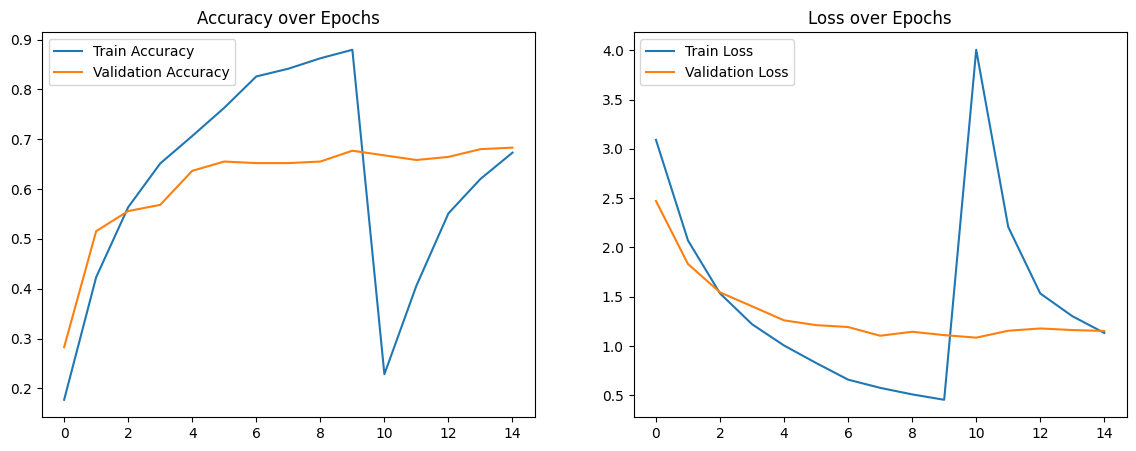

In [18]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [19]:
model.save('/content/drive/MyDrive/tree_species_final_model.h5')
print("✅ Model saved to Google Drive.")


✅ Model saved to Google Drive.
